# Location-Based Consumer Preference Inference

Notebook used for inspection of the GeoLife dataset, retrieved from  
https://www.microsoft.com/en-us/research/project/geolife-building-social-networks-using-human-location-history/#!downloads  
  
The description of the data can be found in the path `<PATH TO GeoLife>`/Geolife Trajectories 1.3/User Guide-1.3.pdf  

In [24]:
from math import sqrt, cos, sin, pi

import os.path

import sqlite3

from datetime import *
import datetime as dt

from geopy.distance import lonlat, distance, vincenty, geodesic

import pandas as pd

import folium
from folium import plugins
#from sklearn.cluster import OPTICS # not officially included at this stage
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import numpy as np

import random;

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.utils import read_sample, timedcall
from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES

In [25]:
def template_clustering(sample, eps, minpts, amount_clusters = None, visualize = True, ccore = False):
    #sample = read_sample(path_sample);
    print("data : ", sample)
    optics_instance = optics(sample, eps, minpts, amount_clusters, ccore);
    (ticks, _) = timedcall(optics_instance.process);
    
    print("Sample: ", sample, "\t\tExecution time: ", ticks, "\n");
    
    if (visualize is True):
        clusters = optics_instance.get_clusters();
        noise = optics_instance.get_noise();
    
        visualizer = cluster_visualizer();
        visualizer.append_clusters(clusters, sample);
        visualizer.append_cluster(noise, sample, marker = 'x');
        visualizer.show();
    
        ordering = optics_instance.get_ordering();
        analyser = ordering_analyser(ordering);
        
        ordering_visualizer.show_ordering_diagram(analyser, amount_clusters);    

In [12]:
#### Retrieve data, based on SELECTION from (SQLite) DB stored in DBFILE, located in PATH
def sqlite_2_pd_df(selection, path, dbfile, db):    
    os.chdir(path)
    con=sqlite3.connect(dbfile)
    con.text_factory = sqlite3.OptimizedUnicode
    query = con.execute("SELECT " + selection + " From " + db)
    cols = [column[0] for column in query.description]
    df= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    return df

In [13]:
#### Test example
#### The file GeoLifeDBMINI.db holds a SQLite DB with the 
workdir = '/home/patrickm/projects/GeoLife/'
DBfile  = 'GeoLifeDBMINI.db'

#### Function calculating length of a trajectory
def time_list(time):
    ln = len(time)
    time.sort()
    return (dt.datetime.strptime( time[len(time)-1], '%H:%M:%S') - dt.datetime.strptime(time[0], '%H:%M:%S')).total_seconds()

def tracklengthGEO(lat, long, alt):
    ln = len(lat)
    trkseg = [ geodesic((lat[i], long[i], alt[i]), (lat[i-1], long[i-i], alt[i-1] )).miles for i in range(ln) ]
    return sum(trkseg)


## test
time1 = '22:29:01'
time2 = '23:30:02'
time = [time1, time2]
print (time_list(time))

3661.0


In [14]:
#### Create dataframe from SQLite DB
df = sqlite_2_pd_df("*", workdir, DBfile, "GeoLifeDBMINI")

In [15]:
# Pandas gymnastics

tmp = df.copy(deep=True)
tmp.reset_index()
tmp.set_index(['usrID','trkID'], inplace = True)
tmp = tmp.groupby(['usrID', 'trkID']).size().to_frame('no of markers')
print(tmp.head(100))
print(tmp.reset_index())


tmp2 = df.copy(deep=True)
tmp2.reset_index()
print (tmp2.loc[tmp2['usrID']==2].head())

                      no of markers
usrID trkID                        
0     20081023025304            908
      20081024020959            244
      20081026134407            745
      20081027115449             50
      20081028003826           1477
      20081029092138             21
      20081029093038            182
      20081103101336              7
      20081103232153           2231
      20081110013637            272
      20081111001704           1477
      20081112023003            681
      20081112091400             27
      20081113034608            494
      20081114015255            337
      20081114101436            305
      20081115010133            281
      20081116085532             12
      20081117051133             81
      20081117155223            314
      20081118095005             32
      20081118095400            254
      20081118162008              7
      20081119012806             81
      20081119112035            419
      20081120035736        

In [16]:
usr = 0

# tracks
mrks = df.loc[df['usrID'] == usr].sort_values(by=['trkID', 'time str'], ascending=True)
print(mrks)

count = 0
for i in mrks['trkID'].unique():
    lat = []
    long= []
    alt = []
    time= []
    count += 1
    
    lat = [lt for lt in mrks.loc[mrks['trkID']==str(i)]['Lat'] ]
    long = [lng for lng in mrks.loc[mrks['trkID']==str(i)]['Long'] ]
    alt = [al for al in mrks.loc[mrks['trkID']==str(i)]['Alt'] ]
    time = [tm for tm in mrks.loc[mrks['trkID']==str(i)]['time str'] ]#.apply(lambda x: dt.strptime(x , '%H:%M:%S').dt.total_seconds() ) ] 
    print(lat)

print (mrks.loc[mrks['time str'] == '02:53:10'].head(20))

             Lat        Long  Alt       no days    date str  time str  usrID  \
67366  39.984702  116.318417  492  39744.120185  2008-10-23  02:53:04      0   
67367  39.984683  116.318450  492  39744.120255  2008-10-23  02:53:10      0   
67368  39.984686  116.318417  492  39744.120313  2008-10-23  02:53:15      0   
67369  39.984688  116.318385  492  39744.120370  2008-10-23  02:53:20      0   
67370  39.984655  116.318263  492  39744.120428  2008-10-23  02:53:25      0   
67371  39.984611  116.318026  493  39744.120486  2008-10-23  02:53:30      0   
67372  39.984608  116.317761  493  39744.120544  2008-10-23  02:53:35      0   
67373  39.984563  116.317517  496  39744.120602  2008-10-23  02:53:40      0   
67374  39.984539  116.317294  500  39744.120660  2008-10-23  02:53:45      0   
67375  39.984606  116.317065  505  39744.120718  2008-10-23  02:53:50      0   
67376  39.984568  116.316911  510  39744.120775  2008-10-23  02:53:55      0   
67377  39.984586  116.316716  515  39744

[39.994622, 39.994622, 39.994614, 39.994602, 39.994599, 39.994599, 39.994601, 39.994584, 39.994593, 39.994564000000004, 39.994549, 39.994551, 39.994547, 39.994554, 39.994609000000004, 39.994664, 39.994714, 39.99478, 39.994849, 39.994911, 39.994976, 39.995028999999995, 39.995096000000004, 39.99517, 39.995224, 39.995287, 39.995360999999995, 39.995429, 39.995472, 39.995529, 39.995573, 39.995616, 39.995781, 39.999249, 39.999392, 39.999424, 39.999386, 39.999342999999996, 39.999348, 39.999466, 39.999545, 40.007143, 40.007178, 40.007227, 40.008922999999996, 40.00887, 40.008815000000006, 40.008767, 40.008767999999996, 40.008796000000004]
[40.01229, 40.012594, 40.012581, 40.012453, 40.012398, 40.012398, 40.012391, 40.012395, 40.012429, 40.012478, 40.012503, 40.01254, 40.012576, 40.012584999999994, 40.012588, 40.012558, 40.012523, 40.01254, 40.012449, 40.012488, 40.012549, 40.012568, 40.012644, 40.012658, 40.012658, 40.012653, 40.012584000000004, 40.011744, 40.011703999999995, 40.01167, 40.01166

[39.999976000000004, 40.000032, 40.000038, 40.000035, 39.996877000000005, 39.996825, 39.996784999999996]
[40.007267, 40.00731, 40.007381, 40.007474, 40.007538000000004, 40.007624, 40.007721000000004, 40.007799, 40.007878000000005, 40.00793, 40.008, 40.008071, 40.008154, 40.008198, 40.008256, 40.008332, 40.008390000000006, 40.008464000000004, 40.008519, 40.008542, 40.008573999999996, 40.008615999999996, 40.008656, 40.008699, 40.008720000000004, 40.008765000000004, 40.008856, 40.008914000000004, 40.008974, 40.009015000000005, 40.009048, 40.009093, 40.009156, 40.009227, 40.009284, 40.009363, 40.009403999999996, 40.009439, 40.009488, 40.009516, 40.009557, 40.009574, 40.009574, 40.009597, 40.009628, 40.009684, 40.00975, 40.009828000000006, 40.009890000000006, 40.00994, 40.009972999999995, 40.010016, 40.010058, 40.010113, 40.010177, 40.010196, 40.010221, 40.010247, 40.010292, 40.010357, 40.010406, 40.010466, 40.010507000000004, 40.010519, 40.010527, 40.010545, 40.010554, 40.010568, 40.010616

[40.008312, 40.00843, 40.00849, 40.008486, 40.008446, 40.00841, 40.008373999999996, 40.008429, 40.008753999999996, 40.008811, 40.008790000000005, 40.008611, 40.008494, 40.008316, 40.008401, 40.008365000000005, 40.008308, 40.008262, 40.0082, 40.008185, 40.00822, 40.00819, 40.008187, 40.008214, 40.008179, 40.008163, 40.008146, 40.008189, 40.008182, 40.008303999999995, 40.008373, 40.008481, 40.008390999999996, 40.008362, 40.008381, 40.0084, 40.008434, 40.008446, 40.008466, 40.008474, 40.008482, 40.008465, 40.008361, 40.008142, 40.007878999999996, 40.007878999999996, 40.007874, 40.008115000000004, 40.008144, 40.008146999999994, 40.008103000000006, 40.008145, 40.008249, 40.008283, 40.008258000000005, 40.008238, 40.008227000000005, 40.008228, 40.008154, 40.008154, 40.008154, 40.008117999999996, 40.008074, 40.008039000000004, 40.008037, 40.00809, 40.008117999999996, 40.008077, 40.008174, 40.008328000000006, 40.008361, 40.008466999999996, 40.008531, 40.008582000000004, 40.008663, 40.0087229999

[40.007591, 40.007604, 40.007528, 40.007446, 40.007303, 40.007187, 40.007039, 40.006879, 40.006671000000004, 40.006378000000005, 40.00633, 40.00628, 40.006159000000004, 40.005973, 40.005812, 40.005644000000004, 40.005503999999995, 40.005349, 40.005213, 40.005053000000004, 40.004931, 40.004818, 40.004663, 40.004455, 40.003775, 40.003616, 40.003807, 40.003734, 40.003603999999996, 40.003422, 40.003221999999994, 40.003032, 40.002864, 40.002691999999996, 40.002532, 40.002376, 40.002188000000004, 40.002031, 40.001906, 40.001821, 40.001689, 40.001565, 40.001459000000004, 40.001388, 40.001346999999996, 40.00122, 40.001102, 40.000971, 40.000814, 40.000595000000004, 40.000364000000005, 40.000147999999996, 40.000978, 40.000823, 40.000698, 40.000541, 40.000375, 40.000271000000005, 40.000161999999996, 40.000074, 39.999928999999995, 39.999765999999994, 39.999548, 39.999464, 39.999387, 39.999293, 39.999235, 39.999152, 39.999086, 39.999036, 39.998992, 39.998984, 39.998940000000005, 39.998894, 39.99888

[40.008224, 40.008302, 40.008289000000005, 40.008289000000005, 40.008285, 40.008254, 40.008146, 40.008071, 40.008019, 40.007978, 40.007915000000004, 40.007857, 40.007818, 40.00773, 40.007671, 40.007668, 40.007665, 40.00763, 40.007626, 40.007678999999996, 40.007699, 40.007721999999994, 40.007729, 40.007646, 40.00747, 40.007337, 40.007182, 40.007022, 40.006852, 40.006678, 40.006499, 40.006314, 40.006166, 40.005959999999995, 40.005790000000005, 40.005592, 40.005386, 40.005193, 40.005067, 40.004954, 40.004801, 40.004612, 40.004451, 40.004241, 40.004023, 40.003825, 40.003671000000004, 40.003532, 40.003408, 40.003304, 40.003172, 40.003035, 40.002869, 40.002684, 40.002532, 40.002396999999995, 40.002249, 40.00204, 40.001833000000005, 40.001652, 40.001483, 40.001231, 40.001002, 40.000809000000004, 40.000648999999996, 40.000524, 40.000384000000004, 40.000258, 40.000081, 39.99993, 39.999848, 39.999784999999996, 39.999727, 39.999744, 39.999761, 39.999749, 39.999784000000005, 39.999784000000005, 39

[39.999955, 39.999831, 39.999793, 39.999748, 39.999684, 39.999638, 39.999717, 39.999792, 39.999796, 39.999788, 39.999813, 39.999838000000004, 39.999883000000004, 39.999983, 40.000131, 40.000279, 40.000456, 40.000652, 40.000852, 40.001056, 40.001247, 40.001416, 40.001569, 40.001703000000006, 40.001784, 40.0019, 40.002137, 40.002276, 40.002469, 40.002683000000005, 40.002849, 40.003014, 40.003198, 40.003359, 40.003547999999995, 40.00377, 40.004114, 40.004445000000004, 40.004718, 40.005088, 40.005331, 40.005527, 40.005744, 40.005949, 40.006127, 40.006324, 40.006478, 40.006662, 40.006840999999994, 40.007003999999995, 40.007208, 40.007374, 40.007540999999996, 40.007676000000004, 40.007748, 40.007742, 40.007736, 40.007743, 40.007733, 40.007726, 40.007923, 40.00808, 40.008234, 40.008361, 40.008532, 40.008637, 40.008718, 40.008798999999996, 40.008891999999996, 40.009027, 40.009149, 40.009312, 40.009442, 40.009519, 40.009522, 40.009475, 40.009403999999996, 40.009325, 40.009254999999996, 40.00915

[40.007225, 40.006816, 40.0066, 40.006488, 40.006298, 40.006142, 40.006003, 40.005762, 40.005623, 40.005508, 40.005371000000004, 40.005108, 40.004915999999994, 40.004811, 40.004678999999996, 40.004540000000006, 40.004385, 40.004401, 40.005, 40.004931, 40.004851, 40.004861, 40.004869, 40.004849, 40.004865, 40.004867, 40.004942, 40.004984, 40.005013, 40.005014, 40.005026, 40.005033000000005, 40.005033000000005, 40.005038, 40.005059, 40.005081, 40.005102, 40.005117999999996, 40.005131, 40.005136, 40.005124, 40.005124, 40.00512, 40.005132, 40.005146999999994, 40.005161, 40.005178, 40.005193, 40.005195, 40.005188000000004, 40.00519, 40.00519, 40.005194, 40.005199, 40.005202000000004, 40.005212, 40.005213, 40.005210999999996, 40.005438, 40.00549, 40.005534000000004, 40.005482, 40.005475, 40.005477, 40.005477, 40.005469, 40.005421000000005, 40.005390000000006, 40.005328000000006, 40.005241999999996, 40.005179, 40.005074, 40.005052, 40.005052, 40.005051, 40.005059, 40.005039000000004, 40.00501

[40.008224, 40.008228, 40.010062, 40.010087, 40.010088, 40.009948, 40.009926, 40.009899, 40.009858, 40.009761, 40.009698, 40.009665000000005, 40.009615999999994, 40.00958, 40.009572, 40.009582, 40.009664, 40.009678, 40.009716999999995, 40.009744, 40.00975, 40.00977, 40.009634000000005, 40.009494000000004, 40.009356, 40.009223999999996, 40.009174, 40.009159000000004, 40.009171, 40.009234, 40.009274, 40.009288, 40.009313, 40.009281, 40.009186, 40.009109, 40.008983, 40.008857, 40.00873, 40.008604999999996, 40.008455, 40.008309999999994, 40.008178, 40.008049, 40.007883, 40.00775, 40.007621, 40.00747, 40.007334, 40.00717, 40.007031, 40.006877, 40.006734, 40.006686, 40.006653, 40.006682, 40.006721999999996, 40.006728, 40.006727000000005, 40.006684, 40.006678, 40.006754, 40.006785, 40.006784, 40.006797999999996, 40.006999, 40.00719, 40.007378, 40.007415, 40.007482, 40.00763, 40.007708, 40.007713, 40.007713, 40.007715999999995, 40.007718, 40.007708, 40.007705, 40.007705, 40.007701000000004, 40

[40.011236, 40.011186, 40.011186, 40.011194, 40.011253, 40.011239, 40.011163, 40.011125, 40.011174, 40.010999, 40.010985, 40.010884999999995, 40.01085, 40.010733, 40.010253000000006, 40.010196, 40.010116, 40.00969, 40.009566, 40.009488, 40.009369, 40.009291, 40.009056, 40.009042, 40.009029, 40.009046999999995, 40.00913, 40.009085, 40.009066, 40.009027, 40.008907, 40.008767999999996, 40.008603, 40.008428, 40.008295000000004, 40.008117, 40.007965999999996, 40.007803, 40.007635, 40.007562, 40.007393, 40.007709000000006, 40.007595, 40.007479, 40.007382, 40.007334, 40.007294, 40.007276, 40.007255, 40.007234000000004, 40.007225, 40.007225, 40.007221, 40.007212, 40.007202, 40.007197, 40.007193, 40.007188, 40.007188, 40.007194, 40.007195, 40.007128, 40.00701, 40.00691, 40.006715, 40.006477000000004, 40.006347999999996, 40.006029999999996, 40.005972, 40.005875, 40.005695, 40.005626, 40.005533, 40.005408, 40.005283, 40.005122, 40.004944, 40.004884999999994, 40.004723999999996, 40.004296999999994

[39.762913, 39.762907, 39.762903, 39.762937, 39.762937, 39.762938, 39.762938, 39.763388, 39.763327000000004, 39.763095, 39.762809999999995, 39.762477000000004, 39.762279, 39.762231, 39.762240999999996, 39.762403000000006, 39.762694, 39.76295, 39.763141, 39.763446, 39.763838, 39.764263, 39.764684, 39.764939, 39.765066999999995, 39.765257, 39.765552, 39.76597, 39.766434999999994, 39.766923999999996, 39.767402000000004, 39.767826, 39.76809, 39.768253, 39.768302, 39.768342, 39.768404, 39.768477000000004, 39.768549, 39.768592, 39.768648999999996, 39.768707, 39.768696999999996, 39.768703, 39.768864, 39.76915, 39.769486, 39.769890000000004, 39.770359, 39.770891999999996, 39.771444, 39.771994, 39.772501, 39.773021, 39.773565000000005, 39.77411, 39.774640999999995, 39.775152, 39.775553, 39.775847, 39.776078999999996, 39.776315999999994, 39.776559000000006, 39.776652, 39.776543, 39.776332000000004, 39.776064, 39.775762, 39.77543, 39.775121, 39.774770000000004, 39.774438, 39.774093, 39.7737429999

[40.009941999999995, 40.009958000000005, 40.010033, 40.010059999999996, 40.010071999999994, 40.010071999999994, 40.010145, 40.010101, 40.010098, 40.010053000000006, 40.009941999999995, 40.009655, 40.00955, 40.009538, 40.009557, 40.00956, 40.009487, 40.009459, 40.009374, 40.009131, 40.008967, 40.008911, 40.008936, 40.008925, 40.008922, 40.008982, 40.008876, 40.008756, 40.008548, 40.008356, 40.008207, 40.008041, 40.00789, 40.007659999999994, 40.007519, 40.007381, 40.007181, 40.006932, 40.006682, 40.006475, 40.00629, 40.006134, 40.005866999999995, 40.005628, 40.005435999999996, 40.005252, 40.005069, 40.004884999999994, 40.004779, 40.00475, 40.00473, 40.004774, 40.004781, 40.00477, 40.004773, 40.004773, 40.004773, 40.004753, 40.004729, 40.004707, 40.004653000000005, 40.004589, 40.004463, 40.004372, 40.004199, 40.004013, 40.003797999999996, 40.003623, 40.003426, 40.003219, 40.003038000000004, 40.002866, 40.002601, 40.002364, 40.002157000000004, 40.001968, 40.001723999999996, 40.001518, 40.0

[39.9998, 39.999814, 39.999819, 39.999836, 39.999839, 39.999884, 39.999863, 39.999867, 39.999897, 39.999953999999995, 39.999928999999995, 39.999922999999995, 40.000029, 40.000323, 40.000365, 40.000434999999996, 40.000383, 40.000396, 40.000422, 40.000495, 40.000519, 40.000591, 40.00073, 40.000883, 40.000992, 40.001084999999996, 40.001142, 40.001236999999996, 40.001296, 40.001329, 40.001346999999996, 40.001414000000004, 40.001513, 40.001597, 40.001697, 40.001765, 40.001877, 40.001940000000005, 40.00203, 40.002121, 40.002195, 40.002293, 40.002369, 40.002389, 40.00248, 40.002471, 40.002455, 40.002435999999996, 40.002437, 40.002416, 40.002382, 40.002438, 40.002549, 40.00265, 40.002789, 40.002908000000005, 40.003084, 40.003232000000004, 40.003372999999996, 40.003498, 40.003541999999996, 40.00357, 40.003537, 40.003535, 40.003535, 40.003566, 40.003556, 40.003510999999996, 40.003515, 40.003515, 40.003538, 40.003541999999996, 40.003547, 40.003547, 40.003546, 40.003567, 40.003643, 40.00372, 40.00

[40.000077000000005, 40.000028, 39.999837, 39.999674, 39.999713, 39.999759000000005, 39.999809, 39.999824, 40.00028, 40.000131, 39.999927, 39.999998, 40.000005, 40.000009000000006, 40.000007000000004, 40.000027, 40.000052000000004, 40.000138, 40.000184000000004, 40.000215999999995, 40.000207, 40.000249, 40.000234999999996, 40.000254, 40.000259, 40.000252, 40.000249, 40.000257, 40.000331, 40.0003, 40.000298, 40.000294, 40.000309, 40.000335, 40.000388, 40.000503, 40.000541999999996, 40.000632, 40.00074, 40.000881, 40.001003000000004, 40.001084000000006, 40.001181, 40.001278000000006, 40.001354, 40.001456, 40.001608000000004, 40.001695, 40.001763000000004, 40.001895000000005, 40.002039, 40.002195, 40.002354, 40.002446, 40.002556, 40.002639, 40.002728000000005, 40.002818, 40.002956, 40.003122, 40.003259, 40.003382, 40.003507, 40.003586999999996, 40.003706, 40.003828000000006, 40.003909, 40.003984, 40.003984, 40.003993, 40.003958000000004, 40.003892, 40.003864, 40.003857, 40.003871000000004

[40.007653999999995, 40.007726, 40.007653000000005, 40.007531, 40.007428000000004, 40.007351, 40.007374, 40.007394, 40.007366, 40.007333, 40.007335999999995, 40.007315999999996, 40.007185, 40.007028999999996, 40.006871000000004, 40.006703, 40.006547, 40.006384999999995, 40.006248, 40.00607, 40.005953000000005, 40.005798999999996, 40.005663, 40.005455, 40.005272999999995, 40.005115999999994, 40.004909999999995, 40.004813, 40.004664, 40.004486, 40.004360999999996, 40.004226, 40.00408, 40.003917, 40.003739, 40.003609000000004, 40.003524, 40.003359, 40.003417999999996, 40.003388, 40.003387, 40.003378000000005, 40.00339, 40.003436, 40.003477000000004, 40.003498, 40.003495, 40.003304, 40.003197, 40.003053, 40.002882, 40.002763, 40.002472999999995, 40.002396000000005, 40.002337, 40.002247, 40.002293, 40.002295000000004, 40.002285, 40.002309000000004, 40.002309999999994, 40.002278999999994, 40.002103999999996, 40.001876, 40.001702, 40.001543, 40.001397, 40.001294, 40.001282, 40.001233, 40.0013

[40.010273, 40.010243, 40.010179, 40.010189000000004, 40.010141, 40.010061, 40.009678, 40.009665000000005, 40.009687, 40.009723, 40.009744, 40.009712, 40.009725, 40.009702000000004, 40.009546, 40.009359, 40.009181, 40.009055, 40.00906, 40.009078, 40.0091, 40.009119, 40.009109, 40.008994, 40.008848, 40.008682, 40.008494, 40.008317, 40.008146999999994, 40.007968, 40.007785999999996, 40.00759, 40.007406, 40.007232, 40.007037, 40.006873999999996, 40.006681, 40.006536, 40.006516999999995, 40.006526, 40.006482, 40.0065, 40.006463000000004, 40.006496999999996, 40.006524, 40.00655, 40.006565, 40.006667, 40.006679, 40.006659, 40.006643, 40.00665, 40.006651, 40.006677, 40.006674, 40.00662, 40.00662, 40.006583, 40.006583, 40.006598, 40.006603000000005, 40.006602, 40.006624, 40.0066, 40.006629, 40.006622, 40.006626000000004, 40.006646999999994, 40.006632, 40.006634999999996, 40.006686, 40.006681, 40.006689, 40.006686, 40.006674, 40.006669, 40.006696000000005, 40.00671, 40.006731, 40.00666500000000

[39.999891999999996, 39.999916999999996, 39.999908000000005, 39.999912, 39.999904, 39.999894, 39.999883000000004, 39.99989, 39.999875, 39.999835, 39.999795, 39.999795, 39.999775, 39.999815999999996, 39.999829999999996, 39.99985, 39.999897999999995, 39.999896, 39.999876, 39.999875, 39.999851, 39.999829999999996, 39.999811, 39.999734000000004, 39.999748, 39.999625, 39.99945, 39.999309999999994, 39.999165000000005, 39.999003, 39.998826, 39.998663, 39.998482, 39.99845, 39.99845, 39.998444, 39.998427, 39.998346000000005, 39.99817, 39.998011, 39.997834999999995, 39.997651, 39.997476, 39.997296999999996, 39.997134, 39.997091999999995, 39.997079, 39.997065, 39.997085999999996, 39.997015999999995, 39.996877000000005, 39.99671, 39.996495, 39.996282, 39.996075, 39.995872999999996, 39.995666, 39.995458, 39.995253999999996, 39.995075, 39.995014000000005, 39.994993, 39.994931, 39.994907, 39.994902, 39.994902, 39.994901, 39.994890000000005, 39.994882000000004, 39.994883, 39.994890000000005, 39.994888

[40.007851, 40.007709999999996, 40.007505, 40.007335, 40.00715, 40.006987, 40.006762, 40.006577, 40.006387, 40.006226, 40.006039, 40.005856, 40.005694, 40.005557, 40.005398, 40.005236, 40.005095000000004, 40.004917, 40.004743, 40.004584, 40.004358, 40.004195, 40.00404, 40.003884, 40.003745, 40.003568, 40.003407, 40.003254999999996, 40.003112, 40.002934, 40.002764, 40.002595, 40.002387, 40.002274, 40.002113, 40.001952, 40.001824, 40.001678000000005, 40.001539, 40.001329999999996, 40.001205, 40.001061, 40.001008, 40.000985, 40.001028000000005, 40.001135999999995, 40.001177, 40.001143, 40.0012, 40.001278000000006, 40.001296, 40.001385, 40.001421, 40.001126, 40.000955, 40.000894, 40.000912, 40.000959, 40.000415999999994, 40.000332, 40.000273, 40.000153999999995, 40.000145, 40.00014, 40.00014, 40.000139000000004, 40.000151, 40.000192999999996, 40.000209000000005, 40.000209000000005, 40.000208, 40.000188, 40.000181, 40.000188, 40.000198, 40.000221999999994, 40.000237, 40.000283, 40.000306, 4

[40.000299, 40.0003, 40.000310999999996, 40.000169, 40.000073, 39.999976000000004, 39.999819, 39.999697, 39.999592, 39.999503000000004, 39.999438, 39.999402, 39.999363, 39.999296, 39.999258000000005, 39.999157000000004, 39.999059, 39.998961, 39.998851, 39.998746000000004, 39.998643, 39.99856, 39.998458, 39.998363, 39.998263, 39.998162, 39.998062, 39.99795, 39.997854, 39.997679999999995, 39.997541999999996, 39.997425, 39.997302000000005, 39.997188, 39.997085, 39.996978000000006, 39.996865, 39.996749, 39.996613, 39.996484, 39.9963, 39.996179999999995, 39.996096, 39.996009, 39.995909000000005, 39.9958, 39.995692, 39.995589, 39.995492999999996, 39.9953, 39.99514, 39.994995, 39.994885, 39.99479, 39.994690000000006, 39.994597999999996, 39.994471999999995, 39.994382, 39.994305, 39.994223999999996, 39.994172, 39.994073, 39.993953000000005, 39.993826, 39.993701, 39.993609, 39.993496, 39.993404999999996, 39.993331, 39.99328, 39.99328, 39.993282, 39.993287, 39.993229, 39.993364, 39.993381, 39.993

[40.010951, 40.010413, 40.010114, 40.010047, 40.009972, 40.009959, 40.009884, 40.009932, 40.009938, 40.01005, 40.010490000000004, 40.010433, 40.010502, 40.010413, 40.010220000000004, 40.010063, 40.009976, 40.009918, 40.009899, 40.009918, 40.009928, 40.009931, 40.010069, 40.010019, 40.009883, 40.009755, 40.009639, 40.00947, 40.009437, 40.00945, 40.009456, 40.009439, 40.009434999999996, 40.009459, 40.009415000000004, 40.009319, 40.009161999999996, 40.008971, 40.008793, 40.008614, 40.008448, 40.008276, 40.008084000000004, 40.007909999999995, 40.007731, 40.007559, 40.007376, 40.007234000000004, 40.007047, 40.006854, 40.006675, 40.006483, 40.006291, 40.006104, 40.005897999999995, 40.005705999999996, 40.005551000000004, 40.005375, 40.005202000000004, 40.004991, 40.004943, 40.004896, 40.004884000000004, 40.004878999999995, 40.004974, 40.005006, 40.005047, 40.005054, 40.005054, 40.005051, 40.004934999999996, 40.004934999999996, 40.004915999999994, 40.004887, 40.004809, 40.004686, 40.0045609999

[39.999992999999996, 39.999959999999994, 39.999947, 39.999947, 39.999955, 39.999946, 39.999918, 39.999895, 39.999897, 39.999889, 39.999926, 39.999942, 40.000011, 39.999932, 39.999916999999996, 39.99993, 39.999934, 39.999975, 39.999983, 40.000002, 39.999997, 40.000009999999996, 40.00002, 39.999990000000004, 39.999962, 39.999939000000005, 39.999958, 40.000003, 40.000068, 40.000152, 40.000246000000004, 40.000322, 40.000403000000006, 40.000465000000005, 40.000615, 40.000702000000004, 40.000772999999995, 40.000906, 40.001002, 40.001135999999995, 40.001248, 40.001364, 40.001494, 40.001585, 40.001676, 40.001767, 40.001853000000004, 40.001938, 40.002018, 40.002168, 40.002317, 40.002417, 40.002534000000004, 40.002668, 40.002813, 40.002928000000004, 40.003082, 40.003165, 40.0033, 40.003405, 40.003516, 40.003603999999996, 40.003716, 40.003890999999996, 40.004073, 40.004355, 40.004511, 40.004664, 40.004766, 40.004868, 40.004991, 40.005123, 40.00523, 40.005346, 40.005523, 40.005665, 40.005775, 40.0

[40.009389, 40.009357, 40.009388, 40.009367, 40.009378000000005, 40.009567, 40.009782, 40.009852, 40.009795000000004, 40.009368, 40.009399, 40.009456, 40.009482, 40.009212, 40.009021000000004, 40.008998, 40.008922, 40.008811, 40.008661, 40.008584, 40.008513, 40.008428, 40.008303999999995, 40.008164, 40.008041, 40.007936, 40.007721999999994, 40.007496, 40.007088, 40.006997, 40.006723, 40.006372, 40.006007000000004, 40.005747, 40.005497, 40.005331, 40.00515, 40.004994, 40.004877, 40.004798, 40.004732000000004, 40.004698, 40.004697, 40.004706, 40.004702, 40.004697, 40.004708, 40.004729, 40.004751, 40.00475, 40.004756, 40.004779, 40.004842, 40.004895, 40.005099, 40.005108, 40.005108, 40.005107, 40.005106, 40.005105, 40.005103999999996, 40.005103999999996, 40.005103999999996, 40.005103999999996, 40.005103000000005, 40.005103000000005, 40.005103000000005, 40.005102, 40.005103000000005, 40.005103000000005, 40.005103000000005, 40.005103000000005, 40.005103000000005, 40.005105, 40.005106, 40.00

[40.000005, 39.999683000000005, 39.999662, 39.999644, 39.999612, 39.999573999999996, 39.999525, 39.999659, 39.999689000000004, 39.999666, 39.999642, 39.999629, 39.999638, 39.999646000000006, 39.999643, 39.999659, 39.999666, 39.999656, 39.999659, 39.999659, 39.999643, 39.999651, 39.999658000000004, 39.999696, 39.999765999999994, 39.999855, 39.999922999999995, 40.000038, 40.000043, 40.000132, 40.000161999999996, 40.000217, 40.000269, 40.000436, 40.000799, 40.0008, 40.000924, 40.001032, 40.001088, 40.001089, 40.001104, 40.001049, 40.000993, 40.000977, 40.000932, 40.000923, 40.000888, 40.000884, 40.000890000000005, 40.000890000000005, 40.000890000000005, 40.001067, 40.001461, 40.001629, 40.001708, 40.001771000000005, 40.001866, 40.001953, 40.001993, 40.002059, 40.002058, 40.002161, 40.002148999999996, 40.002195, 40.002254, 40.002327, 40.002379, 40.002418, 40.002496, 40.002534000000004, 40.002707, 40.002866999999995, 40.002955, 40.003015999999995, 40.00314, 40.003184000000005, 40.003221, 40

[40.007656, 40.007436, 40.007489, 40.007478000000006, 40.007472, 40.007589, 40.007605, 40.007506, 40.007484000000005, 40.007497, 40.007532, 40.007560999999995, 40.007477, 40.007526, 40.007545, 40.007277, 40.006966999999996, 40.006756, 40.006547999999995, 40.00634, 40.006167, 40.006007000000004, 40.005881, 40.005771, 40.005648, 40.005478000000004, 40.005314, 40.00517, 40.005014, 40.004824, 40.004661, 40.004496, 40.004309, 40.004139, 40.003985, 40.003811999999996, 40.003634000000005, 40.003443, 40.003273, 40.003093, 40.002917, 40.002747, 40.002627000000004, 40.002478, 40.002278999999994, 40.002051, 40.001851, 40.001667, 40.001441, 40.001191999999996, 40.000989000000004, 40.000738, 40.000521, 40.000240000000005, 40.000039, 39.999918, 39.999801, 39.999693, 39.999666, 39.999695, 39.999735, 39.999697, 39.999693, 39.999626, 39.999624, 39.999691, 39.999756, 39.999748, 39.999744, 39.999749, 39.999782, 39.999771, 39.99981, 39.999846000000005, 39.999848, 39.99984, 39.999862, 39.999914000000004, 3

[39.98445, 39.9844, 39.984318, 39.984252000000005, 39.984146, 39.984013, 39.983864000000004, 39.983675, 39.983534999999996, 39.983447999999996, 39.983266, 39.983088, 39.982984, 39.982921999999995, 39.982892, 39.982811, 39.982692, 39.982582, 39.982469, 39.982321999999996, 39.982265999999996, 39.982265999999996, 39.982271999999995, 39.982215000000004, 39.982096000000006, 39.981925, 39.981727, 39.981541, 39.98135, 39.981173, 39.981141, 39.981144, 39.98114, 39.98114, 39.98114, 39.981121, 39.981015, 39.980796000000005, 39.980482, 39.98015, 39.979908, 39.979841, 39.979796, 39.97979, 39.979788, 39.979788, 39.97979, 39.979791, 39.979791, 39.97979, 39.979772, 39.979772, 39.979768, 39.979690999999995, 39.979512, 39.979288000000004, 39.979015000000004, 39.978737, 39.978483000000004, 39.97831, 39.978141, 39.9779, 39.977626, 39.97733, 39.977052, 39.97681, 39.976575, 39.976371, 39.976244, 39.976123, 39.975984999999994, 39.975862, 39.975862, 39.975865999999996, 39.975845, 39.975733, 39.975533, 39.975

[39.999953000000005, 39.999936, 39.999927, 39.999933, 39.999699, 39.999665, 39.999546, 39.999365000000004, 39.999282, 39.999218, 39.999183, 39.999168, 39.999163, 39.999165000000005, 39.999066, 39.999062, 39.999145, 39.999558, 39.999583, 39.999611, 39.999642, 39.999697, 39.999763, 39.999842, 39.999916999999996, 40.000011, 40.000457, 40.000531, 40.000469, 40.000461, 40.000469, 40.000502000000004, 40.000676, 40.001045, 40.001567, 40.001717, 40.001692999999996, 40.001628000000004, 40.001599, 40.001635, 40.001659000000004, 40.001812, 40.002424, 40.002654, 40.002806, 40.00287, 40.002966, 40.003081, 40.003263000000004, 40.003377, 40.003403000000006, 40.003471000000005, 40.003537, 40.003572999999996, 40.003633, 40.003671000000004, 40.003825, 40.003858, 40.003908, 40.004028000000005, 40.004209, 40.004506, 40.004628000000004, 40.004713, 40.004829, 40.005084000000004, 40.004994, 40.004985999999995, 40.005072999999996, 40.005057, 40.005131, 40.005161, 40.005266999999996, 40.005297, 40.005275, 40.0

[39.871602, 39.871602, 39.871602, 39.871584999999996, 39.871552, 39.871548, 39.871543, 39.871552, 39.871552, 39.871559999999995, 39.871569, 39.871584000000006, 39.871596999999994, 39.871604, 39.871619, 39.871642, 39.871672, 39.871629, 39.871749, 39.871827, 39.871807000000004, 39.871777, 39.871753000000005, 39.871743, 39.871731, 39.871752, 39.871804, 39.871846999999995, 39.871894, 39.871935, 39.871994, 39.872032, 39.872104, 39.872122, 39.872177, 39.872292, 39.872329, 39.872359, 39.872394, 39.872463, 39.872513, 39.872559, 39.872631, 39.872728, 39.8728, 39.872822, 39.872833, 39.872840999999994, 39.872859000000005, 39.872865000000004, 39.872828000000005, 39.872819, 39.872794, 39.872772999999995, 39.872717, 39.872687, 39.872735, 39.872735, 39.87273, 39.872758000000005, 39.872815, 39.872875, 39.872906, 39.87295, 39.872999, 39.873027, 39.872975, 39.872969, 39.87295, 39.87292, 39.872896000000004, 39.872882000000004, 39.872857, 39.872820000000004, 39.872786, 39.872749, 39.872713, 39.872679, 39.

[40.004171, 40.004197999999995, 40.004273, 40.004356, 40.004482, 40.004688, 40.004805, 40.004938, 40.005162, 40.005297, 40.005578, 40.005776000000004, 40.00566, 40.005655, 40.006082, 40.006192, 40.006458, 40.006741, 40.007021, 40.007008, 40.007265000000004, 40.007564, 40.007630999999996, 40.007728, 40.007940000000005, 40.008084000000004, 40.008016, 40.008218, 40.008479, 40.008433000000004, 40.008345, 40.008333, 40.008393, 40.008485, 40.008437, 40.008472, 40.00846, 40.007484999999996, 40.007494, 40.007487, 40.007475, 40.007459999999995, 40.007565, 40.00756, 40.007553, 40.007553, 40.007559, 40.007560999999995, 40.007567, 40.007557, 40.007523, 40.007445000000004, 40.007647999999996, 40.007630999999996, 40.007622, 40.007607, 40.007632, 40.007675, 40.007782, 40.007888, 40.007917, 40.007898, 40.00789, 40.007981, 40.00815, 40.008271, 40.008388000000004, 40.008568, 40.008733, 40.008944, 40.009091999999995, 40.009143, 40.009202, 40.009228, 40.009246999999995, 40.009278, 40.009254999999996, 40.0

[40.007688, 40.007712, 40.007712, 40.007706, 40.007746000000004, 40.007740999999996, 40.007366999999995, 40.007618, 40.007655, 40.007659000000004, 40.007647, 40.007643, 40.007638, 40.007452, 40.007251000000004, 40.007036, 40.006824, 40.006664, 40.006485, 40.006315, 40.006153000000005, 40.006007000000004, 40.005807, 40.005639, 40.005479, 40.005322, 40.005114, 40.004961, 40.004819, 40.004687, 40.004615, 40.004604, 40.004612, 40.004618, 40.004618, 40.004614000000004, 40.004605, 40.004605, 40.0046, 40.004591, 40.004581, 40.004575, 40.004574, 40.004574, 40.004571, 40.004552000000004, 40.004532, 40.004532, 40.004525, 40.004513, 40.004484000000005, 40.004449, 40.004414000000004, 40.004383000000004, 40.004348, 40.004324, 40.004324, 40.004328, 40.004346000000005, 40.004364, 40.004391, 40.004518, 40.004527, 40.004529999999995, 40.004523999999996, 40.004523999999996, 40.004527, 40.004545, 40.004514, 40.004436, 40.004342, 40.004193, 40.004053000000006, 40.003910999999995, 40.003783, 40.003627, 40.

[40.006638, 40.00666, 40.006648999999996, 40.006663, 40.006724, 40.006777, 40.006769, 40.006769, 40.006764000000004, 40.006761, 40.007104, 40.007057, 40.007001, 40.006875, 40.006925, 40.006986, 40.006954, 40.006946, 40.006935, 40.006946, 40.006802, 40.006531, 40.006306, 40.00614, 40.005948, 40.005739, 40.005539, 40.005340999999994, 40.005161, 40.004974, 40.004785, 40.004615, 40.004442, 40.004244, 40.004045, 40.003842999999996, 40.003639, 40.003439, 40.003271999999996, 40.003058, 40.002846999999996, 40.002651, 40.002403, 40.002226, 40.002081, 40.001886999999996, 40.001682, 40.001447, 40.001272, 40.000997, 40.000769, 40.000574, 40.000388, 40.000207, 39.999970000000005, 39.999767999999996, 39.999567, 39.999403, 39.999241999999995, 39.999159999999996, 39.999179999999996, 39.999225, 39.999241999999995, 39.999294, 39.999319, 39.999347, 39.999373999999996, 39.999396000000004, 39.999472999999995, 39.999555, 39.999486, 39.999448, 39.999493, 39.999503999999995, 39.999506, 39.999722, 39.999788, 3

[40.123481, 40.123468, 40.12352, 40.123611, 40.123681, 40.123749, 40.123785999999996, 40.12383, 40.12386, 40.123940999999995, 40.123985, 40.124014, 40.124055, 40.124105, 40.124188000000004, 40.124239, 40.124313, 40.124379, 40.124418, 40.124468, 40.124516, 40.12457, 40.124635, 40.124691, 40.124735, 40.124753999999996, 40.124818, 40.124863, 40.124918, 40.124986, 40.125019, 40.12502, 40.125043, 40.125034, 40.125014, 40.124992, 40.124981, 40.124487, 40.124409, 40.124223, 40.12401, 40.123816999999995, 40.123664, 40.123672, 40.123659, 40.123492999999996, 40.123276000000004, 40.123041, 40.122842999999996, 40.122648999999996, 40.122457, 40.122279, 40.122135, 40.122068, 40.122021999999994, 40.121951, 40.121908000000005, 40.121836, 40.121790000000004, 40.12178, 40.121774, 40.121827, 40.121896, 40.12195, 40.121901, 40.121952, 40.122012, 40.122143, 40.122265999999996, 40.122283, 40.122271999999995, 40.122265000000006, 40.122264, 40.122446999999994, 40.122455, 40.12245, 40.12245, 40.12245, 40.12245

[40.000345, 40.000334, 40.000357, 40.000357, 40.000398, 40.000458, 40.000382, 40.000384999999994, 40.000372, 40.000353999999994, 40.000351, 40.000294, 40.000273, 40.000186, 40.000127, 40.000161999999996, 40.00025, 40.000214, 40.000212, 40.000234999999996, 40.000321, 40.000302000000005, 40.000276, 40.000335, 40.000415000000004, 40.000415999999994, 40.000440999999995, 40.00051, 40.000485999999995, 40.000471999999995, 40.000473, 40.0005, 40.000516, 40.000617999999996, 40.000632, 40.0006, 40.000584, 40.000576, 40.000558000000005, 40.000622, 40.000648999999996, 40.000819, 40.000934, 40.001089, 40.001221, 40.001422, 40.001661999999996, 40.001924, 40.002148999999996, 40.002435999999996, 40.002624, 40.002874, 40.003071999999996, 40.003304, 40.003506, 40.003679999999996, 40.003966999999996, 40.004211, 40.004288, 40.004315000000005, 40.003605, 40.003639, 40.003659999999996, 40.003677, 40.003693, 40.003706, 40.003716, 40.003748, 40.003799, 40.003817, 40.003976, 40.004001, 40.003995, 40.00399, 40.

[40.007705, 40.007705, 40.007702, 40.007721000000004, 40.007711, 40.007521999999994, 40.007385, 40.007253999999996, 40.007127000000004, 40.006982, 40.0067, 40.006606, 40.006559, 40.006534, 40.006495, 40.006566, 40.00658, 40.006549, 40.006499, 40.006474, 40.006474, 40.006474, 40.006481, 40.006488, 40.006496999999996, 40.006493, 40.006392, 40.00626, 40.006093, 40.005947, 40.005719, 40.005525, 40.005327, 40.005027, 40.00483, 40.00473, 40.004669, 40.004659000000004, 40.004643, 40.004633, 40.004659000000004, 40.004690000000004, 40.004655, 40.004611, 40.004556, 40.004528, 40.004498999999996, 40.004472, 40.004554, 40.004523, 40.004389, 40.004334, 40.004342, 40.004247, 40.003963, 40.003733000000004, 40.003502000000005, 40.003284, 40.003076, 40.002837, 40.002635, 40.002418, 40.002198, 40.001994, 40.001782, 40.001588, 40.001376, 40.001169, 40.00094, 40.000719000000004, 40.000485, 40.000262, 39.999984000000005, 39.999773, 39.999552, 39.999367, 39.999195, 39.99895, 39.998673, 39.998565, 39.998598,

[40.007633, 40.00765, 40.007567, 40.007434, 40.007365, 40.007425, 40.007456, 40.007386, 40.007402, 40.007411, 40.007405, 40.007203000000004, 40.007032, 40.006859000000006, 40.006686, 40.00653, 40.006372999999996, 40.006192999999996, 40.006033, 40.005795, 40.005682, 40.005518, 40.005331, 40.005158, 40.005025, 40.004917999999996, 40.00479, 40.004633, 40.004473, 40.004315999999996, 40.004189000000004, 40.004037, 40.003869, 40.003640000000004, 40.003439, 40.003251, 40.003056, 40.002909, 40.002796000000004, 40.002651, 40.002465, 40.002228, 40.002022, 40.00179, 40.001647999999996, 40.001471, 40.001283, 40.0011, 40.000953, 40.000799, 40.000608, 40.000423, 40.000202, 39.999934, 39.999695, 39.999623, 39.999595, 39.999615999999996, 39.999629999999996, 39.999649, 39.999672, 39.99969, 39.999702, 39.999742, 39.999784999999996, 39.999868, 39.999914000000004, 39.999866, 39.999814, 39.999772, 39.999753000000005, 39.999744, 39.999744, 39.999771, 39.999829, 39.999944, 40.000079, 40.000111, 40.000103, 40

[31.296514000000002, 31.296529999999997, 31.296458, 31.296365, 31.296244, 31.296183000000003, 31.296144, 31.296175, 31.296164, 31.296146999999998, 31.29615, 31.296122999999998, 31.296103000000002, 31.296066999999997, 31.295596000000003, 31.295489, 31.295405, 31.295305, 31.295194, 31.295105, 31.295022999999997, 31.294925, 31.294826, 31.294758, 31.294666999999997, 31.294574, 31.294479, 31.294642, 31.294560999999998, 31.294493, 31.294413, 31.294309000000002, 31.294233000000002, 31.294147, 31.294074, 31.294032, 31.294096999999997, 31.294214, 31.294354, 31.294484999999998, 31.294611, 31.294762, 31.294901, 31.295116999999998, 31.295166, 31.295287, 31.2954, 31.295484000000002, 31.295562, 31.295565999999997, 31.295572999999997, 31.295592, 31.295625, 31.295648999999997, 31.295658000000003, 31.295692, 31.295713, 31.295703000000003, 31.295697999999998, 31.295703999999997, 31.295723, 31.296946000000002, 31.295993, 31.295679999999997, 31.295689000000003, 31.296301, 31.296340999999998, 31.29637, 31.

[40.00756, 40.007581, 40.007573, 40.007474, 40.007335, 40.007288, 40.007323, 40.007353, 40.007366999999995, 40.00735, 40.007368, 40.007290999999995, 40.007128, 40.006938, 40.006772999999995, 40.006661, 40.006491, 40.006273, 40.006064, 40.005894, 40.005756, 40.00562, 40.005475, 40.00527, 40.00509, 40.004948, 40.004777000000004, 40.004634, 40.004465, 40.004301, 40.004162, 40.003994, 40.003864, 40.003756, 40.003612, 40.003415000000004, 40.003265, 40.003097, 40.002901, 40.002784999999996, 40.002617, 40.002474, 40.002299, 40.002099, 40.001954, 40.001839000000004, 40.001598, 40.001435, 40.001191999999996, 40.00087, 40.000687, 40.0005, 40.000296999999996, 40.000081, 39.999883000000004, 39.99972, 39.999662, 39.999665, 39.999722, 39.999772, 39.999794, 39.999796999999994, 39.999790999999995, 39.999736, 39.999635999999995, 39.999645, 39.999677, 39.999656, 39.999553000000006, 39.999502, 39.999427000000004, 39.999371000000004, 39.999354, 39.999357, 39.999378, 39.999445, 39.999601, 39.999751, 39.999

[39.996603, 39.996652000000005, 39.996691, 39.996694, 39.996703000000004, 39.996713, 39.996684, 39.996693, 39.99669, 39.99669, 39.996693, 39.996726, 39.996808, 39.996828, 39.996815000000005, 39.996796, 39.996795, 39.996795, 39.996794, 39.996771, 39.996767, 39.996764, 39.996763, 39.996758, 39.996755, 39.996752, 39.996749, 39.996745000000004, 39.996744, 39.996736999999996, 39.996736999999996, 39.996735, 39.996711, 39.996696, 39.996677000000005, 39.996663, 39.996651, 39.996634, 39.996609, 39.996590000000005, 39.996565999999994, 39.996595, 39.996629999999996, 39.996606, 39.996593, 39.99658, 39.99658, 39.996572, 39.996569, 39.996536, 39.996494, 39.996412, 39.996309000000004, 39.996115, 39.996015, 39.995799, 39.995544, 39.995377000000005, 39.995339, 39.995336, 39.995328, 39.995328, 39.995327, 39.995289, 39.995202, 39.995090000000005, 39.994976, 39.994974, 39.994974, 39.994976, 39.994903, 39.994824, 39.994748, 39.994748, 39.994745, 39.994684, 39.994566999999996, 39.994376, 39.994181, 39.99404

[39.99984, 39.999899, 40.000017, 40.000234000000006, 40.000363, 40.000565, 40.000766, 40.000923, 40.001124, 40.00119, 40.001199, 40.001195, 40.001232, 40.001358, 40.001519, 40.001737, 40.001983, 40.002171000000004, 40.002393, 40.002642, 40.002879, 40.003133, 40.003386, 40.003577, 40.003754, 40.003975, 40.00428, 40.004529, 40.004779, 40.005093, 40.00522, 40.005448, 40.005688, 40.006009000000006, 40.006204, 40.006387, 40.006605, 40.0066, 40.006589, 40.006572, 40.006582, 40.006594, 40.00658, 40.006594, 40.006596, 40.006586, 40.006584000000004, 40.006721999999996, 40.006937, 40.007133, 40.007309, 40.007311, 40.007282000000004, 40.007267999999996, 40.007253999999996, 40.007369, 40.007521000000004, 40.007647, 40.007696, 40.007696, 40.007665, 40.007734, 40.00781, 40.007822, 40.007277, 40.007399, 40.007318, 40.007160999999996, 40.006994, 40.006809000000004, 40.006523, 40.006289, 40.006091999999995, 40.005911, 40.00575, 40.005577, 40.005364, 40.005171000000004, 40.005004, 40.004888, 40.004748, 

## Stay Points location
  
  In the following we try out an algorithm used to find so-called *stay points*. Currently it appears ugly, and I am hoping that a more elegant and efficient algorithm will be found.  
  The algorithm works as follows:
  * For each user $u_i$, for each trajectory $traj_{u_i, j}$: run a clustering algorithm (SPcandidates) among the time stamps pertaining to each set of coordinates. This creates a list of time stamps $\{ t_m, \ldots, t_n \}$ where $| t_i - t_j | \geq T_{\mathrm{threshold}}$  (20min in this particular case), for $t_i, t_j \in \{ t_m, \ldots, t_n \}$.
  * Use the same type of clustering algorithm (clust) to see if the coordinates corresponding to the aforementioned timestamps fulfill the criteria $\mathrm{dist}\left ( (\mathrm{lat}_i, \mathrm{long}_i), (\mathrm{lat}_j, \mathrm{long}_j) \right) \leq D_{\mathrm{threshold}}$ (200m in this particular case)
  * If the time stamp and corresponding coordinates fulfull the abovemenentioned criteria then a *stay point* is calculated

In [17]:
def SPcandidates(timelst):
    prev = None
    group = []
    Tth = 20.*60.
### Step one: cluster wrt. time
    for tm in timelst:
        if not prev or (abs(time_list([tm, prev])) >= Tth):
            group.append(tm)
        else:
            yield group
            group = [tm]
        prev = tm
    if group:
        yield group

tmpdct = dict(enumerate(SPcandidates(time), 1)) # dictionary of time stamps more than 20 min apart
times = tmpdct.values()

def clust(lat, long):
    coords = list(zip(lat,long))
    #coords = map(lambda x,y : (x,y),lat,long)
    #print("DO IT NOW!!! ", coords)
    prev = (None, None)
    group = []
    Dth = 200.
    #test = (geodesic(coords, prev).m)
    for coord in coords:
        if not prev or ((geodesic(coord, prev).m) <= Dth):
            group.append(coord)
        else:
            yield group
            group = [coord]
        prev = coord
    if group:
        yield group
        
#dict(enumerate(SPcandidates(time), 1))

Tt = 20 * 60. # threshold in seconds
Dt = 200.

SPs = []
for i in mrks['trkID'].unique():
    lat = []
    long= []
    alt = []
    time= []
    count += 1
    
    lat = [lt for lt in mrks.loc[(mrks['trkID']==str(i)) ]['Lat'] ]
    long = [lng for lng in mrks.loc[mrks['trkID']==str(i)]['Long'] ]
    alt = [al for al in mrks.loc[mrks['trkID']==str(i)]['Alt'] ]
    time = [tm for tm in mrks.loc[mrks['trkID']==str(i)]['time str'] ]
    
#    if count%20 == 0: print ("Trajectory ", i, " SP candidates ", StayPointFind(lat, long, alt, time, Tt, Dt) )
    if count%20 == 0: print ("Trajectory ", i, " SP candidates ",  [time for time in dict(enumerate(SPcandidates(time), 1)).values() if len(time)>1] )
    SP = []
    tmarrs = [time for time in dict(enumerate(SPcandidates(time), 1)).values() if len(time)>1]
    for tmarr in tmarrs:
        lat = [lt for tim in tmarr for lt in mrks.loc[(mrks['trkID']==str(i) )& (mrks['time str'] == str(tim)) ]['Lat'] ] 
        long = [lng for tim in tmarr for lng in mrks.loc[(mrks['trkID']==str(i) )& (mrks['time str'] == str(tim)) ]['Long'] ] 
        coordlst = list(dict(enumerate(clust(lat,long), 1)).values())
        coordlst = coordlst[1:]
        SP.append((coordlst, tmarr))
            #lat  = [lt for lt in mrks.loc[mrks['trkID']==str(i) & mrks['time str'] == tim]['Lat'] ]
            #long = [lt for lt in mrks.loc[mrks['trkID']==str(i) & mrks['time str'] == tim]['Long'] ]
        #print ("Trajectory ", i, " SP candidates ",  [coord for coord in dict(enumerate(clust(lat,long), 1)).values() ] )
    #print("SP ??? : ", SP)
    print("coordlist : ", coordlst)
    #print("coordlist[0] : ", coordlst[0])
    #print("coordlist[0][1]", coordlst[0][1])
    #print("coordlist[:][:][:][:][0]", coordlst[:][:][:][:][0])
    sumlat = 0.
    sumlong= 0.
    for coord in coordlst[0]:
        sumlat += coord[0]
        sumlong+= coord[1]
    SPs.append( (sumlat/len(coordlst[0]), sumlong/len(coordlst[0])) ) 

print("Stay points :", SPs )

coordlist :  [[(40.008945000000004, 116.321551), (40.008851, 116.32148500000001)]]
coordlist :  [[(40.008945000000004, 116.321551), (40.008851, 116.32148500000001)]]
coordlist :  [[(40.008945000000004, 116.321551), (40.008851, 116.32148500000001)]]
coordlist :  [[(40.008945000000004, 116.321551), (40.008851, 116.32148500000001)]]
coordlist :  [[(39.999557, 116.324312)], [(40.007635, 116.31963600000002)]]
coordlist :  [[(39.999557, 116.324312)], [(40.007635, 116.31963600000002)]]
coordlist :  [[(39.999557, 116.324312)], [(40.007635, 116.31963600000002)]]
coordlist :  [[(39.999557, 116.324312)], [(40.007635, 116.31963600000002)]]
Trajectory  20081103232153  SP candidates  [['00:27:16', '00:52:33'], ['03:31:08', '23:21:53']]
coordlist :  [[(39.999659, 116.324747)], [(39.996947999999996, 116.32574699999999)]]
coordlist :  [[(39.9741, 116.332416), (39.974876, 116.33185)]]
coordlist :  [[(39.9741, 116.332416), (39.974876, 116.33185)]]
coordlist :  [[(40.009471000000005, 116.320475), (40.0089

coordlist :  [[(40.008202000000004, 116.319449), (40.007220000000004, 116.31926299999999)]]
coordlist :  [[(40.005459, 116.326076), (40.005559000000005, 116.326191)]]
coordlist :  [[(39.995484999999995, 116.32889399999999), (39.995638, 116.328973)]]
coordlist :  [[(40.010114, 116.31491799999999)], [(40.011266, 116.312591)]]
coordlist :  [[(40.010114, 116.31491799999999)], [(40.011266, 116.312591)]]
coordlist :  [[(40.003083000000004, 116.326163), (40.002943, 116.32604099999999)]]
Trajectory  20090519094537  SP candidates  [['09:57:17', '10:20:01'], ['10:32:07', '11:22:38']]
coordlist :  [[(39.999801, 116.32710800000001), (39.999871999999996, 116.32731399999999)]]
coordlist :  [[(39.999801, 116.32710800000001), (39.999871999999996, 116.32731399999999)]]
coordlist :  [[(40.000448999999996, 116.32728300000001), (39.999935, 116.32739)]]
coordlist :  [[(40.000448999999996, 116.32728300000001), (39.999935, 116.32739)]]
coordlist :  [[(40.000448999999996, 116.32728300000001), (39.999935, 116.

## Experimenting with the OPTICS clustering algorithm

data :  [(40.008898, 116.321518), (40.008898, 116.321518), (40.008898, 116.321518), (40.008898, 116.321518), (39.999557, 116.324312), (39.999557, 116.324312), (39.999557, 116.324312), (39.999557, 116.324312), (39.999659, 116.324747), (39.974488, 116.332133), (39.974488, 116.332133), (40.009226, 116.32045450000001), (40.009226, 116.32045450000001), (40.0007515, 116.324095), (40.007423, 116.319784), (40.009337, 116.322098), (40.009839, 116.32113100000001), (40.009839, 116.32113100000001), (40.009839, 116.32113100000001), (40.009839, 116.32113100000001), (40.009839, 116.32113100000001), (39.9934085, 116.3275835), (39.9934085, 116.3275835), (39.9934085, 116.3275835), (40.011368, 116.320901), (40.011368, 116.320901), (40.011368, 116.320901), (40.011368, 116.320901), (40.000284, 116.32430500000001), (40.000284, 116.32430500000001), (40.000284, 116.32430500000001), (40.000284, 116.32430500000001), (40.008238, 116.322253), (40.008238, 116.322253), (40.008238, 116.322253), (39.999965, 116.32455

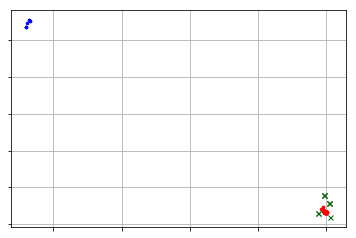

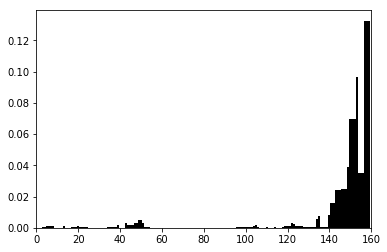

In [31]:
eps = 0.15
minpts = 3
template_clustering(SPs, eps, minpts)

## Playing with Folium
  
  Here we play with the folium package for python and plot markers corresponding to trajectory files.

In [41]:
BEIJING_COORDINATES = ( 39.9062170, 116.3912757 )
# for speed purposes
MAX_RECORDS = 1000
  
# create empty map zoomed in on Beijing
map_beijing = folium.Map(location=BEIJING_COORDINATES, zoom_start=12)
map_beijing.position
# add a marker for every record in the filtered data, use a clustered view

usr = 0

tmp  = df.copy(deep=True)
main = tmp[tmp['trkID'] == str(20090415074008)]
lat  = main['Lat'].tolist()
long = main['Long'].tolist()

coord = []

for lt in lat:
    coord.append( (lt, long[ lat.index(lt) ] ) ) 
    print("coord = ", lt, long[ lat.index(lt) ])
    folium.Marker(location = (lt, long[ lat.index(lt) ] ) ).add_to(map_beijing)
    
#for each in crimedata[0:MAX_RECORDS].iterrows():
#    folium.Marker(location = [each[1]['Latitude'],each[1]['Longitude']]).add_to(mapsf)
#map.save(outfile = "test.html")
map_beijing


coord =  39.942822 116.79588500000001
coord =  39.942822 116.79588500000001
coord =  39.942788 116.795947
coord =  39.942795000000004 116.79590800000001
coord =  39.942774 116.795929
coord =  39.942741 116.795924
coord =  39.942725 116.79593200000001
coord =  39.942721999999996 116.79593600000001
coord =  39.94272 116.79593500000001
coord =  39.94272 116.79593500000001
coord =  39.942717 116.795928
coord =  39.942721999999996 116.79593600000001
coord =  39.942732 116.795907
coord =  39.942698 116.795933
coord =  39.942612 116.795934
coord =  39.942558 116.796
coord =  39.942471999999995 116.795949
coord =  39.94236 116.79562
coord =  39.942358 116.795331
coord =  39.942332 116.795201
coord =  39.942316999999996 116.795185
coord =  39.942322 116.795174
coord =  39.942322 116.795174
coord =  39.942319 116.795171
coord =  39.94231 116.795171
coord =  39.942296999999996 116.795174
coord =  39.942292 116.79498799999999
coord =  39.942215000000004 116.7947
coord =  39.942113 116.794252
coord

coord =  39.995535 116.326388
coord =  39.995556 116.32633999999999
coord =  39.995551 116.326327
coord =  39.995558 116.32631200000002
coord =  39.995558 116.32631200000002
coord =  39.995557 116.326311
coord =  39.995694 116.326321
coord =  39.995809 116.32633100000001
coord =  39.99597 116.326376
coord =  39.996097 116.326397
coord =  39.996177 116.32640900000001
coord =  39.996241999999995 116.32647800000001
coord =  39.996269 116.326594
coord =  39.996347 116.326664
coord =  39.996491 116.326621
coord =  39.996658000000004 116.32658400000001
coord =  39.996825 116.32656399999999
coord =  39.99705 116.326674
coord =  39.997253 116.326719
coord =  39.99743 116.32676599999999
coord =  39.997583 116.326756
coord =  39.997724 116.32672600000001
coord =  39.99788 116.32668899999999
coord =  39.998048 116.32668799999999
coord =  39.99821 116.32668100000001
coord =  39.99836 116.326668
coord =  39.998562 116.326696
coord =  39.998738 116.326677
coord =  39.998907 116.326656
coord =  39.99

coord =  39.939809000000004 116.777651
coord =  39.939642 116.776575
coord =  39.939462 116.77552800000001
coord =  39.939301 116.77452199999999
coord =  39.939166 116.77358600000001
coord =  39.939042 116.772681
coord =  39.938886 116.771735
coord =  39.938682 116.770784
coord =  39.938461 116.76988999999999
coord =  39.938224 116.76908
coord =  39.937965000000005 116.76835200000001
coord =  39.937746000000004 116.76781799999999
coord =  39.937598 116.76747399999999
coord =  39.937453999999995 116.76713400000001
coord =  39.937284999999996 116.766703
coord =  39.937048 116.76616999999999
coord =  39.936795000000004 116.765606
coord =  39.936639 116.76518300000001
coord =  39.936512 116.76484599999999
coord =  39.936383 116.764546
coord =  39.936264 116.76426200000002
coord =  39.936073 116.76386699999999
coord =  39.935852000000004 116.76338500000001
coord =  39.935766 116.762992
coord =  39.93581 116.762697
coord =  39.935859 116.762348
coord =  39.935891 116.762074
coord =  39.93588

coord =  40.008474 116.32420400000001
coord =  40.008626 116.324178
coord =  40.008787 116.324168
coord =  40.008936 116.324155
coord =  40.00908 116.32413600000001
coord =  40.009221999999994 116.324128
coord =  40.009356 116.324118
coord =  40.009485999999995 116.324075
coord =  40.009599 116.323975
coord =  40.00963 116.32379499999999
coord =  40.009607 116.32361000000002
coord =  40.009597 116.32344599999999
coord =  40.009584999999994 116.323237
coord =  40.009606 116.32301499999998
coord =  40.009609999999995 116.32283400000001
coord =  40.009648999999996 116.32266899999999
coord =  40.009771 116.32258200000001
coord =  40.009871999999994 116.322584
coord =  40.009939 116.32261299999999
coord =  40.009989000000004 116.322643
coord =  40.01003 116.32266899999999
coord =  40.010053000000006 116.32265500000001
coord =  40.010055 116.32263799999998
coord =  40.010054 116.322639
coord =  40.010056 116.32263200000001
coord =  40.010056 116.32263200000001
coord =  40.010057 116.32262800